Key features in v7:

1. Use user defined class to create a trading environment
2. A portfolio is created to enjoy the benefit of diversification

## Import Library

In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import ta

from tensorflow import keras
from tensorflow.keras import layers, models

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Defining Functions

### Feature Engineering

In [ ]:
def addSMA(data, sma_start: int, sma_end: int, sma_step: int):
    sma_range = range(sma_start, sma_end, sma_step)

    for window in sma_range:
        # SMA/Close
        # relative value of SMA to closing price
        data.loc[:,f"SMA_{window}"] = ta.trend.SMAIndicator(data.Close, window=window).sma_indicator() / data.Close

    for i in range(len(sma_range)):
        for j in range(i+1, len(sma_range)):
            # (SMA_1 - SMA_2) / Close
            data.loc[:,f"SMA_DELTA_{sma_range[i]}_{sma_range[j]}"] = data.loc[:,f"SMA_{sma_range[i]}"] - data.loc[:,f"SMA_{sma_range[j]}"]

    return data

In [ ]:
def addEMA(data, ema_start: int, ema_end: int, ema_step: int):
    ema_range = range(ema_start, ema_end, ema_step)

    for window in ema_range:
        # EMA/Close
        # relative value of EMA to closing price
        data.loc[:,f"EMA_{window}"] = ta.trend.EMAIndicator(data.Close, window=window).ema_indicator() / data.Close

    for i in range(len(ema_range)):
        for j in range(i+1, len(ema_range)):
            # (EMA_1 - EMA_2) / Close
            data.loc[:,f"EMA_DELTA_{ema_range[i]}_{ema_range[j]}"] = data.loc[:,f"EMA_{ema_range[i]}"] - data.loc[:,f"EMA_{ema_range[j]}"]

    return data

In [ ]:
def feature_generation(
    data,
    sma_start: int = 20,
    sma_end  : int = 100,
    sma_step : int = 20,
    ema_start: int = 20,
    ema_end  : int = 100,
    ema_step : int = 20
    ):
    """
    Input
    --------
    X: pd.DataFrame


    Output
    --------
    X: pd.DataFrame
    """
    close = data.Close

    # SMA
    data = addSMA(data=data, sma_start=sma_start, sma_end=sma_end, sma_step=sma_step)

    # EMA
    data = addEMA(data=data, ema_start=ema_start, ema_end=ema_end, ema_step=ema_step)

    # RSI
    data["RSI"] = ta.momentum.RSIIndicator(data.Close).rsi()
  
    # MACD
    data["MACD"] = ta.trend.MACD(data.Close).macd()

    # ATR
    data["ATR"] = ta.volatility.AverageTrueRange(data.High, data.Low, data.Close).average_true_range()

    # BollingerBands
    upper = ta.volatility.BollingerBands(data.Close).bollinger_hband()
    lower = ta.volatility.BollingerBands(data.Close).bollinger_lband()

    data["BB_upper"] = (upper - close) / close
    data["BB_lower"] = (lower - close) / close
    data["BB_width"] = (upper - lower) / close

    # Garman Klass Volatility
    data["garman_klass_vol"] = ((np.log(data.High)-np.log(data.Low))**2)/2-(2*np.log(2)-1)*((np.log(data.Close)-np.log(data.Open))**2)

    return data

In [ ]:
def preprocess(data,
               PCA_components = 8):
  # Feature generation
  data_features = feature_generation(data)

  # Feature
  remove_columns = ["Open",
                    "High",
                    "Low",
                    "Close"]
  features = data_features.drop(remove_columns, axis=1).dropna()

  # normalize
  scaler = StandardScaler()
  features = pd.DataFrame(
    scaler.fit_transform(features),
    index=features.index,
    columns=features.columns)

  # PCA
  pca = PCA(n_components=PCA_components)
  features = pd.DataFrame(
    pca.fit_transform(features),
    index=features.index)
  
  return features

In [ ]:
def create_LSTM_input(data, time_steps=10):
    num_samples = data.shape[0] - time_steps + 1
    X = np.array([data[i:i+time_steps] for i in range(num_samples)])
    return X


## Defining Model

In [ ]:
class LSTM_stack(layers.Layer):
    """stacks of LSTM with dropout, followed by dense layer"""

    def __init__(
        self,
        dropout_rate: float = 0.2
        ):
        super().__init__()

        self.lstm_1 = layers.LSTM(
            units=50,
            return_sequences=True,
            )

        self.lstm_2 = layers.LSTM(
            units=50,
            return_sequences=True,
            )

        self.lstm_3 = layers.LSTM(
            units=50,
            return_sequences=False,
            )

        self.dense_1 = layers.Dense(
            units=1
            )

        self.dropout_1 = layers.Dropout(dropout_rate)

    def call(self, inputs):
        x = self.lstm_1(inputs)
        x = self.dropout_1(x)
        x = self.lstm_2(inputs)
        x = self.dropout_1(x)
        x = self.lstm_3(inputs)
        x = self.dropout_1(x)
        return self.dense_1(x)

## Defining Trading Environment

In [ ]:
class Coin:
    def __init__(self, symbol, ohlcv):
        self.symbol = symbol
        self.ohlcv = ohlcv
        self.logret = self.calculate_logret()
        self.trading_history = []  # List to store trading history
        self.volatility = self.calculate_volatility()
        self.features = preprocess(
            pd.concat([
                self.ohlcv,
                self.logret,
                self.volatility],
                axis=1))
        self.y = self.logret.shift(-1)

    def calculate_logret(self):
        return pd.DataFrame(
            np.log((self.ohlcv.Close / self.ohlcv.Close.shift(1)))).rename(columns={"Close": "logret"})

    def calculate_volatility(self):
        return pd.DataFrame(
            self.logret.rolling(window=14).std()).rename(columns={"logret": "vol"})

In [ ]:
class Market:
    def __init__(
        self,
        cash = 10000):
        self.coins = {}  # Dictionary to store coins
        self.init_cash = cash
        self.cash = self.init_cash  # Initial cash balance
        self.assets = {}  # Dictionary to store quantity of each asset
        self.prices = pd.DataFrame()

    def add_coin(self, coin):
        self.coins[coin.symbol] = coin
        self.assets[coin.symbol] = 0  # Initialize asset quantity to 0

        close = pd.DataFrame(coin.ohlcv.Close).rename(columns={"Close": coin.symbol})
        self.prices = pd.concat([self.prices, close], axis=1)
        
        self.coins[coin.symbol].trading_history = []
        self.coins[coin.symbol].position = "Closed"

    def reset_cash(self):
        self.cash = self.init_cash

    def trade(self, symbol, action, quantity, price, time):
        if action == "buy":
            cost = quantity * price
            if self.cash >= cost:
                self.cash -= cost
                self.assets[symbol] += quantity
                self.coins[symbol].trading_history.append(
                    {
                        "action": "buy",
                        "quantity": quantity,
                        "price": price,
                        "time": time
                    })
                self.coins[symbol].position = "Long"
            else:
                print("Insufficient funds to buy!")
        elif action == "sell":
            if self.assets[symbol] >= quantity:
                self.cash += quantity * price
                self.assets[symbol] -= quantity
                self.coins[symbol].trading_history.append(
                    {
                        "action": "sell",
                        "quantity": quantity,
                        "price": price,
                        "time": time
                    })
                self.coins[symbol].position = "Closed"
            else:
                print("Insufficient assets to sell!")
        else:
            print("Invalid action. Use 'buy' or 'sell'.")

## Parameters

This section contains all the parameters.

In [ ]:
symbols = [
    "ADAUSDT",
    "BNBUSDT",
    "BTCUSDT",
    "EOSUSDT",
    "ETHUSDT",
    "LTCUSDT",
    "NEOUSDT",
    "QTUMUSDT",
    "XRPUSDT"
    ]

interval = "15m"

## Training the Model

This section outputs training and testing data for the use of the following sections.

### Creating the market for training the model

In [ ]:
market_train = Market()
for symbol in symbols:
    data_train = pd.read_csv(f"Binance Data/Training/{interval}/{symbol}.csv", index_col="index")
    data_train = data_train.set_index(pd.DatetimeIndex(pd.to_datetime(data_train.index)))
    coin = Coin(symbol, data_train)
    market_train.add_coin(coin)

In [ ]:
market_val = Market()
for symbol in symbols:
    data_val = pd.read_csv(f"Binance Data/Validation/{interval}/{symbol}.csv", index_col="index")
    data_val = data_val.set_index(pd.DatetimeIndex(pd.to_datetime(data_val.index)))
    coin = Coin(symbol, data_val)
    market_val.add_coin(coin)

In [ ]:
market_test = Market()
for symbol in symbols:
    data_test = pd.read_csv(f"Binance Data/Testing/{interval}/{symbol}.csv", index_col="index")
    data_test = data_test.set_index(pd.DatetimeIndex(pd.to_datetime(data_test.index)))
    coin = Coin(symbol, data_test)
    market_test.add_coin(coin)

### Initializing the model

In [ ]:
inputs = keras.Input((10, 8)) # Hard-coded timestep and number of features
outputs = LSTM_stack()(inputs)
model = keras.Model(inputs, outputs)
optimizer = keras.optimizers.Adam()
loss      = keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer,loss=loss)

### Training the model

In [ ]:
for symbol in symbols:
    X_train = create_LSTM_input(market_train.coins[symbol].features)[:-1]
    y_train = market_train.coins[symbol].logret[-X_train.shape[0]:]

    X_val = create_LSTM_input(market_val.coins[symbol].features)[:-1]
    y_val = market_val.coins[symbol].logret[-X_val.shape[0]:]
    model.fit(
        X_train, y_train,
        epochs = 2,
        validation_data=(X_val, y_val))

### Testing the model

In [61]:
buy_threshold = 0.5
sell_threshold = -0.5

results = {}

for symbol in symbols:
    market_test.reset_cash()
    X_test = create_LSTM_input(market_test.coins[symbol].features)

    scaler = StandardScaler()
    prediction = scaler.fit_transform(model.predict(X_test))

    test_time = market_test.coins[symbol].features[-len(X_test):].index

    account_values = np.zeros((len(test_time)))
    for index, time in enumerate(test_time):
        if market_test.coins[symbol].position == "Closed" and prediction[index] > buy_threshold:
            budget = market_test.cash * 0.999
            price = market_test.prices.loc[time, symbol]
            qty = budget / price
            # print(f"Long. Cash: {cash}. Price: {price}. Quantity: {qty}")
            market_test.trade(symbol, "buy", qty, price, time)
        if market_test.coins[symbol].position == "Long" and prediction[index] < sell_threshold:
            price = market_test.prices.loc[time, symbol]
            qty = market_test.assets[symbol]
            # print(f"Close. Cash: {cash}. Price: {price}. Quantity: {qty}")
            market_test.trade(symbol, "sell", qty, price, time)
        account_values[index] = market_test.cash + market_test.assets[symbol] * market_test.prices.loc[time, symbol]

    if market_test.coins[symbol].position == "Long":
        price = market_test.prices.loc[time, symbol]
        qty = market_test.assets[symbol]
        market_test.trade(symbol, "sell", qty, price, time)
    account_values[index] = market_test.cash + market_test.assets[symbol] * market_test.prices.loc[time, symbol]

    results[symbol] = account_values

1090/1090 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


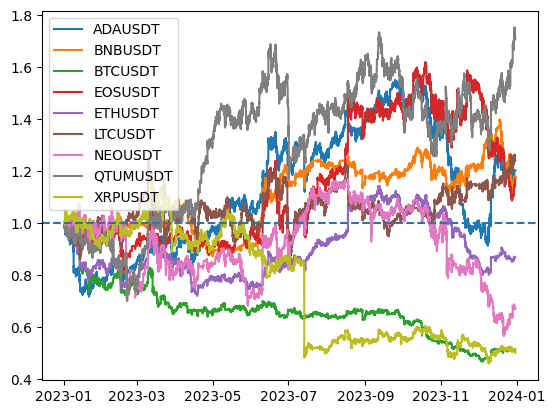

In [71]:
for symbol in symbols:
    buy_and_hold = market_test.prices.loc[test_time,symbol] / market_test.prices.loc[test_time[0],symbol]
    strategy_pl = results[symbol] / results[symbol][0]
    score = strategy_pl / buy_and_hold

    plt.plot(
        test_time,
        score,
        label = symbol
    )

plt.axhline(y=1, linestyle='--')

plt.legend()
plt.show()

In [ ]:
scaler = StandardScaler()

plt.hist(
    scaler.fit_transform(prediction),
    bins=1000,
    label=symbol)
plt.xlim(-2, 2)
# plt.ylim(0, 5000)
plt.show()

# To Do
- test with simple strategy
    - only one asset in a portfolio
    - test which asset performs the best
    - check G/L distribution at different time
    - see if can mitigate loss by creating a portfolio
- Model volatility and trade option

In [ ]:
for timestep, prices_snapchot in market.prices.iterrows():
    

## Backtesting

## Results

## Ad hoc

In [ ]:
counter = 1
symbols = market.prices.columns

for symbol in symbols:
    print(market.coins[symbol].features[:10])

In [ ]:
for symbol in market.coins:
    plt.hist(
        market.coins[symbol].features,
        bins=100,
        alpha=0.3,
        label=symbol)
    break
plt.xlim(-15, 15)
# plt.ylim(0, 5000)
plt.show()

In [ ]:
for symbol in market.coins:
    plt.hist(
        market.coins[symbol].volatility,
        bins=100,
        alpha=0.3,
        label=symbol)
plt.xlim(-.01, .05)
plt.ylim(0, 5000)
plt.show()

In [ ]:
for symbol in market.coins:
    vol    = market.coins[symbol].autocorrelation
    print(f"{symbol}: {vol * 100}")

In [ ]:
plt.plot(market.coins["QTUMUSDT"].ohlcv.Close)
plt.show()